## How I got interested in Gaussian Processes

A few weeks ago I saw a paper passing on the arXiv by [Aigrain & Foreman-Mackey](https://arxiv.org/abs/2209.08940) which is a review on Gaussian Processes (GPs) from an astrophysical perspective - it is actually targeted for astronomical time-series. I had heard a lot of things about GPs before, but I never really had the time nor will to sit down an actually understand what they are about. That changed when I glanced over the review by Aigrain & Foreman-Mackey, as I quickly realised a couple of things that caught my interest.

In particular, the thing that struck me the most is their Figure 3. This appears at the end of the first Section of the review, which is mostly dedicated to two *motivating examples* from astronomical time-series analysis (a very well-crafted first Section I must say!).
This shows the fit of a mock exoplanet transit lightcurve by two models: the both share the same physics, which is also used to generate the mock dataset, but one takes into account the correlated noise in the data, while the other doesn't and therefore works under the assumption that the datapoints are all uncorrelated and independent.

GPs are used to realistically represent the correlation in the time-series data typically observed for exoplanet transits and are an ingredient used to generate the mock dataset. So the final outcome of this controlled experiment is that *only the model that accounts for correlated data, modelled with a GP, is able to recover reasonably well the true physical parameters, while the other* **model without a GP infers a severely biased result**. 

It is interesting to notice that in this example the GP introduces another layer of uncertainty in the model (i.e. how are the data correlated) over which we have to marginalise in order to arrive at the final prediction for the physical parameters. This means that *the simple model that treats the data as independent is very confidently inferring a biased result (with relatively high accuracy), as opposed to the model with a GP which is instead less accurate, but unbiased.*

## Gaussian Processes (GPs) in rotation curve modelling

In this notebook I'm going to explore how we can use GPs in modelling rotation curves of galaxies. Often - pretty much always - circular velocity measurements in galaxies are treated as independent and parametrized rotation curve models are fitted to such datasets without worrying too much if that is a reasonable assumption. Given that most HI rotation curves are derived with a [tilted-ring model](https://ui.adsabs.harvard.edu/abs/1974ApJ...193..309R/abstract), I am unconfortable with assuming that each datapoint in a rotation curve is actually independent from all the others, since adjacent rings can easily enter the line-of-sight of a given radius.

For this reason I am going to generate a mock rotation curve dataset where the points are actually correlated. This will be done using a GP. Then I will be fitting this dataset with two models: one assuming that the data are independent, and another taking into account the correlated noise.

In [1]:
#| code-fold: true
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import jax
import jax.numpy as jnp
import jaxopt
from functools import partial
from tinygp import GaussianProcess, kernels
import numpyro
import arviz
import corner

jax.config.update("jax_enable_x64", True)
import warnings
warnings.filterwarnings('ignore')

%config Completer.use_jedi = False
%matplotlib inline

rng = np.random.default_rng()

### Definitions and rotation curve sampling

Define the mathematical functions for the galaxy rotation curves

In [2]:
G, H, Dc = 4.301e-9, 70, 200.

# accessory functions
def jax_fc(x): return jnp.log(1+x)-x/(1+x)
def jax_Vvir(Mh): return jnp.sqrt((Dc*(H)**2/2)**(1./3.) * (G*Mh)**(2./3.))
def jax_Rvir(Mh):
    rho_hat = 4. / 3. * np.pi * Dc * (3. * (H)**2 / (8. * np.pi * G))
    return 1e3 * ((Mh / rho_hat)**(1./3.))

# actual rotation curve
def jax_vhalo(params, R):
    Mh, cc = 10**params['log_mh'], 10**params['log_c']    
    rv = jax_Rvir(Mh)
    return jnp.sqrt(jax_Vvir(Mh)**2*rv/R*jax_fc(cc*R/rv)/jax_fc(cc)) 

Lat's now plot a randomly sampled rotation curve with a typical error on each datapoint of 8 km/s. As a first step, we will assume that each datapoint is independent and thus we will sample from a Gaussian noise distribution for each measurement.

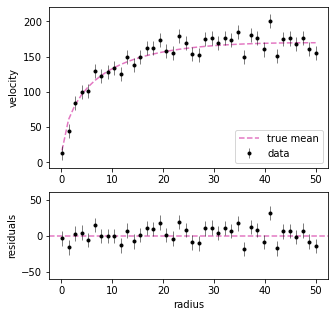

In [3]:
size = 40
lmh, lc, verr = 12, 0.95, 10.0

# generating independent datapoints with Gaussian errors
x = np.linspace(0.1, 50, size)
y = jax_vhalo({'log_mh':lmh, 'log_c':lc}, x) + rng.normal(loc=0, scale=verr, size=size)

fig,ax = plt.subplots(figsize=(5,5), nrows=2, gridspec_kw={'height_ratios':(0.65,0.35)})
# rotation curve
ax[0].plot(x, jax_vhalo({'log_mh':lmh, 'log_c':lc}, x), '--', c='tab:pink', label='true mean')
ax[0].errorbar(x, y, yerr=verr, fmt='.', c='k', lw=0.5, label='data')
ax[0].legend(loc='lower right')
ax[0].set_ylabel('velocity');
# residuals
ax[1].axhline(y=0, ls='--', c='tab:pink')
ax[1].errorbar(x, y-jax_vhalo({'log_mh':lmh, 'log_c':lc}, x), yerr=verr, fmt='.', c='k', lw=0.5)
ax[1].set_xlabel('radius')
ax[1].set_ylabel('residuals')
ax[1].set_ylim(-60,60);

In the simple case plotted above we have generated the points with the implicit assumption that each datapoint was independent from all the others. This is why mathematically we simply added a Gaussian noise term to the median curve when defining `y`. In the residuals plot, the fact that each datapoint is independent becomes apparent since there is no clear trend in the residuals as a function of radius.

However, in practice this is rarely the case with astronomical observations, since typically instrumental characteristics of the telescope and physical processes make the measurement of a single datapoint to have a non-negligible dependence on some other datapoints. Most of the times when modelling astrophysical data we do not know precisely if and which measurements are correlated with which others, so it is in our best interest to employ a modelling technique that allows for correlated datapoints, instead of assuming they are independent.
This is where GPs come into play.

### Generating rotation curve data with correlated noise using GPs

Let's now use GPs to generate a new set of datapoints, but this time they will be correlated to one another. To specify this correlation we need to define a `kernel` or a covariance function which, in the simplest case that we are using here, is a function only of the physical distance of each point (absolute or L1 distance). 

Kernels that depend only of the distance of points are called *stationary*. A very common kernel function used in GPs is the so-called *radial basis function (RBF)* or exponential-squared, since $k(x_i, x_j) \propto \exp\left[-\frac{1}{2}(d_{ij}/s)^2\right]$, where $d_{ij}=|x_i-x_j|$ is the distance of the two datapoints, while $s\in\mathbb{R}$ is a scale parameter.

#### Build the GP with tinygp

We define the GP as follows using the library [tinygp](https://tinygp.readthedocs.io/en/stable/index.html).

In [4]:
def build_gp(params, x, yerr):
    kernel = 10**params['log_amp']*kernels.ExpSquared(10**params['log_scl'], distance=kernels.distance.L1Distance())
    return GaussianProcess(kernel, 
                           x, 
                           diag=yerr**2, 
                           mean=partial(jax_vhalo, params)
                          )

This GP has 2 adjustable parameters: an amplitude `log_amp` and a scale `log_scl` (both defined in log). We build the GP by passing it the kernel function, the set of datapoints (just `x`, not the velocity measurements), the measured uncertainty of the measurements, and the mean function that needs to be added to the noise generated by the GP.

What the library is doing is just building a full covariance matrix on the dataset `x` using the kernel function provided. The value that we pass on the `diag` argument will be considered as an additional variance to be added to the covariance matrix. 

Let's now initialize a GP with some amplitude and scale parameters and let's sample random datapoints from its covariance matrix.

In [5]:
params = {'log_mh':lmh, 'log_c':lc,
          'log_amp':jnp.log10(300.0), 'log_scl':jnp.log10(5.0)}

# initialize the GP and sample from it
gp   = build_gp(params, x, verr)
# vm   = gp.sample(jax.random.PRNGKey(11))
vm   = gp.sample(jax.random.PRNGKey(33))
e_vm = np.sqrt(gp.variance)

Here `gp.sample` gets a random realization of y-measurements on the `x`-array. We can define their standard *errorbars* by just taking the variances (i.e. diagonal of the covariance matrix).

#### The covariance matrix

Just to help out with visualising the GP, let's plot the covariance matrix for this problem.

In [6]:
def plt_mat(ax, params, x, yerr):

    gp = build_gp(params, x, yerr)
    
    xm1, xm2 = jnp.meshgrid(x,x)
    zm = np.zeros_like(xm1.flatten())
    for i in range(len(xm1.flatten())):
        zm[i]=(gp.kernel.evaluate(xm1.flatten()[i], xm2.flatten()[i]))
        
    im=ax.matshow(zm.reshape((len(x), len(x))), extent=(x.min(), x.max(), x.max(), x.min()))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)

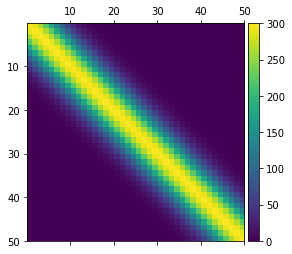

In [272]:
fig,ax = plt.subplots()
plt_mat(ax, params, x, verr)

Here each point is coloured according to the covariance $k(x_i,x_j)$. It is highest along the diagonal, where $k(x_i,x_i)=300$ km$^2$/s$^2$, implying a standard uncertainty on each data point of $\sigma=\sqrt{300+10^2}=20$ km/s, where the term $10^2$ comes from adding the measured uncertainties to the covariance matrix (the `diag` argument in `GaussianProcess`). Given the kernel function and the scale of $5$ that we used in this example, we can see that each datapoint has a significant correlation with all the points closer than ~10.

#### Sampling the rotation curve with correlated noise

Finally, let's plot the sampled rotation curve and its residuals and let's compare them with the uncorrelated case above.

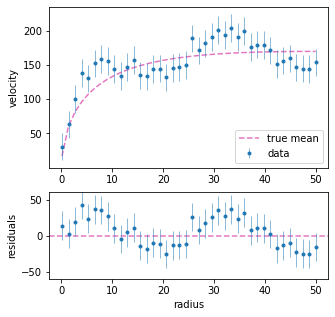

In [7]:
fig,ax = plt.subplots(figsize=(5,5), nrows=2, gridspec_kw={'height_ratios':(0.65,0.35)})
# rotation curve
ax[0].plot(x, jax_vhalo({'log_mh':lmh, 'log_c':lc}, x), '--', c='tab:pink', label='true mean')
ax[0].errorbar(x, vm, yerr=e_vm, fmt='.', c='C0', lw=0.5, label='data')
ax[0].legend(loc='lower right')
ax[0].set_ylabel('velocity');
# residuals
ax[1].axhline(y=0, ls='--', c='tab:pink')
ax[1].errorbar(x, vm-jax_vhalo({'log_mh':lmh, 'log_c':lc}, x), yerr=e_vm, fmt='.', c='C0', lw=0.5)
ax[1].set_xlabel('radius')
ax[1].set_ylabel('residuals')
ax[1].set_ylim(-60,60);

We do see quite a lot of structure in the residuals plot this time! This is in stark contrast to the picture we had when generating datapoints independently. This time each measurements *feels* the influence of the other measurements closer than ~10 in radius, thus the rotation curve starts having significant trends above and below the mean.

When fitting the rotation curve these trend can be misinterpreted as signal, instead of just correlated noise, and this can potentially bias our inference on the curve parameters quite significantly. We see below an example of this.

### Fitting the rotation curve with or without Gaussian Processes

Let's now consider the rotation curve generated with the GP above, i.e. the blue set of points, and let's build a model to fit it. The model is the same `jax_vhalo` function that we used to generate the data, which has 2 free parameters: a mass `log_mh` and a concentration `log_c`.

We run the fit in a Bayesian framework and in particular with an MCMC sampler using a standard $\chi^2$ log-likelihood on the observed datapoints. We impose a uniform prior on `log_mh` and normal prior on `log_c`, whose mean follows the well-known mass-concentration relation of dark matter halos in $\Lambda$CDM [(Dutton & Maccio' 2014)](https://ui.adsabs.harvard.edu/abs/2014MNRAS.441.3359D/abstract).

We use the library [numpyro](https://num.pyro.ai/en/latest/index.html#) to define the model and to run the MCMC sampling. In particular, numpyro uses a state-of-the-art Hamiltonian *No U-Turn Sampler (NUTS)* to derive the posterior of the parameters. 

We run the fit two times: the first time, we treat the datapoints as independent and we have a "standard" Bayesian inference on the parameters; the second time, we allow the data to be correlated and we model their correlation with a GP with an exp-squared kernel that has two additional free parameters, an amplitude `log_amp` and a scale `log_scl`.
We impose an uniformative uniform prior on the two parameters of the kernel.

#### Model without GP

In [10]:
# radial grid to define the output of the GP
r_grid = jnp.linspace(0.1, 50.0, 1000)

def model(t, y_err, y, use_gp=False):
    
    # priors
    log_mh = numpyro.sample('log_mh', numpyro.distributions.Uniform(8.0,  14.0)) 
    log_c  = numpyro.sample('log_c',  numpyro.distributions.Normal(0.905-0.101*(log_mh-12.0), 0.15)) 
    
    # parameters of the underlying physical model
    params = {"log_mh": log_mh, 
              "log_c" : log_c}
    
    if use_gp:
        # branch WITH GPs
        # 
        # define kernel parameters
        params["log_amp"] = numpyro.sample("log_amp", numpyro.distributions.Uniform(-4.0, 5.0))
        params["log_scl"] = numpyro.sample("log_scl", numpyro.distributions.Uniform(-2.0, 3.0))
        
        # generate the GP
        gp = build_gp(params, t, y_err)
        
        # sample the posterior
        numpyro.sample("y", gp.numpyro_dist(), obs=y)
        
        # calculate properties of the model
        mu = gp.mean_function(r_grid)
        numpyro.deterministic("mu", mu)
        numpyro.deterministic("gp", gp.condition(y, r_grid, include_mean=False).gp.loc)

    else:
        # branch WITHOUT GPs
        #
        # sample the posterior
        numpyro.sample("y", numpyro.distributions.Normal(jax_vhalo(params, t), y_err), obs=y)
        
        # calculate properties of the model
        numpyro.deterministic("mu", jax_vhalo(params, r_grid))

#### Sampling the posterior with numpyro

The `model` function above has the `numpyro` primitives like `numpyro.sample` that are used by the NUTS MCMC sampler to construct the posterior. Below we run the model the first time selecting the `use_gp=False` branch, i.e. assuming that the data are independent.

We launch 2 chains for 3000 steps (of which 1/3 of warmup) of the NUTS sampler, starting from a specific value of the parameters that is not too far from the truth (to convieniently speed up convergence). We then use the [`arviz`](https://arviz-devs.github.io/arviz/) package to evaluate some statistics on the posterior samples.

In [345]:
sampler_wn = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        model,
        dense_mass=True,
        target_accept_prob=0.9,
        init_strategy=numpyro.infer.init_to_value(values={'log_mh':11.0, 'log_c':1.0}),
    ),
    num_warmup=1000,
    num_samples=3000,
    num_chains=2,
    progress_bar=True,
)
%time sampler_wn.run(jax.random.PRNGKey(11), x, e_vm, vm)

inf_data_wn = arviz.from_numpyro(sampler_wn)
arviz.summary(inf_data_wn, var_names=["log_mh", "log_c"])

sample: 100%|████████████████████████████████████████████████████████████████████| 4000/4000 [00:11<00:00, 357.45it/s, 3 steps of size 7.96e-01. acc. prob=0.93]


CPU times: user 18.3 s, sys: 1.07 s, total: 19.4 s
Wall time: 23.4 s


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_mh,11.897,0.060,11.786,12.009,0.001,0.001,4581.0,3535.0,1.0
log_c,1.087,0.058,0.983,1.200,0.001,0.001,4758.0,3911.0,1.0


#### Explore the MCMC samples with arviz

The posterior has been successfully sampled and we can now have a look at the marginalized distributions of the two physical parameters, mass and concentration.

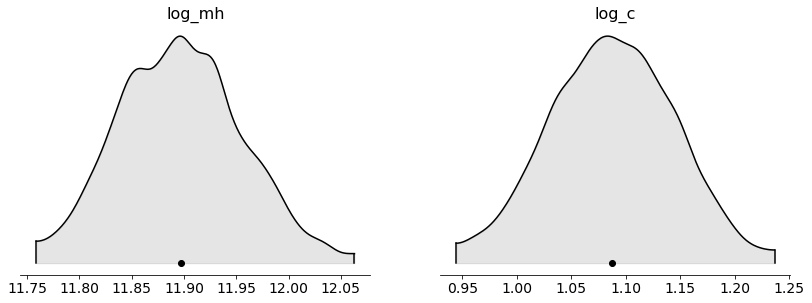

In [346]:
arviz.plot_density(inf_data_wn, var_names=["log_mh", "log_c"], hdi_prob=0.99, colors='k', shade=0.1);

#### Model with GP

Let's now repeat the fitting procedure, but this time for the `use_gp=True` branch of `model`, i.e. allowing for the data to be correlated.

In [347]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        model,
        dense_mass=True,
        target_accept_prob=0.9,
        init_strategy=numpyro.infer.init_to_value(values={'log_mh':11.0, 'log_c':1.0, 
                                                          'log_amp':1.0, 'log_scl':0.5
                                                         }),
    ),
    num_warmup=1000,
    num_samples=3000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(11), x, e_vm, vm, use_gp=True)

inf_data = arviz.from_numpyro(sampler)
arviz.summary(inf_data, var_names=["log_mh", "log_c", "log_amp", "log_scl"])

sample: 100%|███████████████████████████████████████████████████████████████████| 4000/4000 [00:14<00:00, 273.18it/s, 31 steps of size 1.56e-01. acc. prob=0.97]


CPU times: user 1min, sys: 2.38 s, total: 1min 2s
Wall time: 44.9 s


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_mh,11.974,0.261,11.525,12.476,0.006,0.004,2440.0,1578.0,1.0
log_c,0.989,0.142,0.716,1.258,0.003,0.002,2553.0,2809.0,1.0
log_amp,2.723,0.647,1.929,3.712,0.039,0.027,942.0,580.0,1.0
log_scl,0.840,0.233,0.517,1.143,0.008,0.008,1543.0,1419.0,1.0


In this case, we have two additional free parameters that are the amplitude and scale of the GP kernel. These can be considered as *nuisance* parameters in the present case, since we are only interested in the distributions of the two physical parameters marginalized over everything else.

The chain statistics summarized above look great, but let's inspect the plot of the autocorrelation time to be extra sure that all the chains are converged and well-behaved.

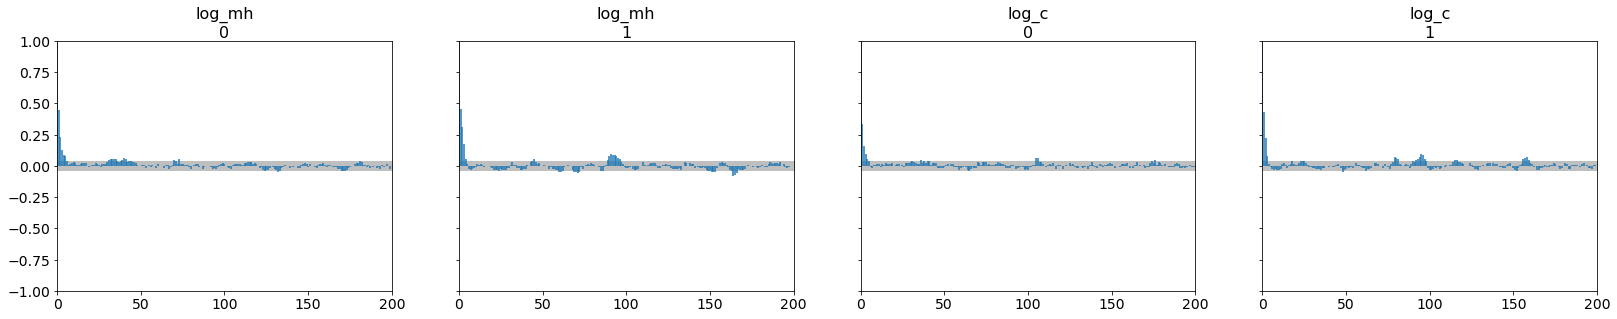

In [348]:
arviz.plot_autocorr(inf_data, var_names=["log_mh", "log_c"], max_lag=200);

From this plot we can see that the autocorrelation of both parameters for all chains tends to die out for sufficiently large lags. This confirms that the MCMC samples that we have derived are actually independent and can be reliably used to infer the posterior.

Let's now compare the marginalized distributions of `log_mh` and `log_c` between the two modeling runs.

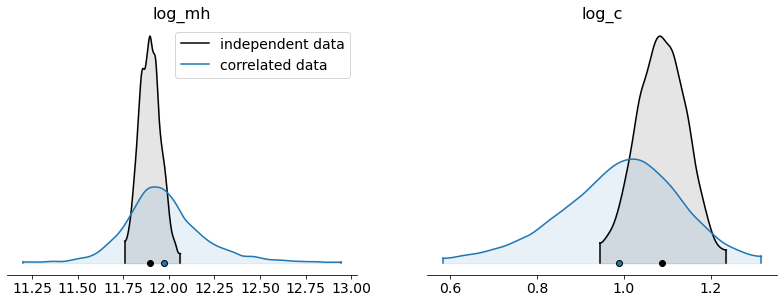

In [349]:
arviz.plot_density([inf_data_wn, inf_data], var_names=["log_mh", "log_c"],
                   data_labels=["independent data", "correlated data"],
                   hdi_prob=0.99, colors=['k','C0'], shade=0.1);

We clearly see that if we working under the assumption of uncorrelated data the resulting posteriors are thinner and somewhat biased. On the other hand, by allowing the data to be correlated in the fit, as modelled by a GP, the resulting posterior are significantly wider and more uncertain, but are significantly less biased. 

#### Comparing the 2 models with a corner plot

Let's have a look at the [corner](https://corner.readthedocs.io/en/latest/) plot of the marginalised posterior distribution in the mass-concentration space. 

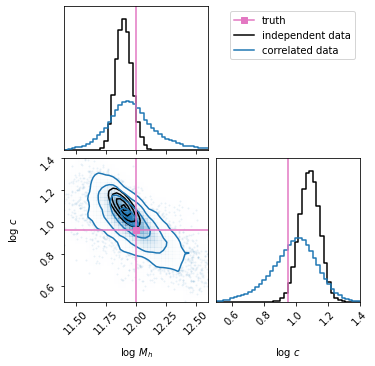

In [393]:
ranges = [(11.4, 12.6), (0.5, 1.4)] # PRNG 33
fig = corner.corner(inf_data_wn, bins=40, range=ranges, 
                    color="k", var_names=["log_mh", "log_c"], smooth=1.0, smooth1d=1.0
                   )
fig = corner.corner(inf_data, bins=40, range=ranges, 
                    color="C0", var_names=["log_mh", "log_c"], smooth=1.0, smooth1d=1.0,
                    labels=["$\log\,M_h$", "$\log\,c$"],
                    truths=[params['log_mh'], params['log_c']], truth_color='tab:pink',
                    fig=fig)

# make legend
ax = fig.axes[1]
key_tr = matplotlib.lines.Line2D([], [], color='tab:pink', linestyle='-', marker='s', label='truth')
key_nn = matplotlib.lines.Line2D([], [], color='k',    linestyle='-', label='independent data')
key_gp = matplotlib.lines.Line2D([], [], color='C0',   linestyle='-', label='correlated data')
ax.legend(loc='upper right', handles=[key_tr, key_nn, key_gp]);

This figure shows more clearly how the first run of the fit, assuming independent data, infers a clearly biased (lower) mass and (higher) concentration. On the other hand, when including a GP in the model to account for correlations in the data the posterior on $M_h$ and $c$ becomes perfectly compatible with the true value within 1-$\sigma$.

#### Predicted rotation curves of the 2 models

Finally, let's plot the predicted rotation curves of the two models in comparison with the data.

In [382]:
# get predictions excluding MCMC warmup phase
pred_wn = sampler_wn.get_samples(group_by_chain=True)['mu'][:,1000:,:].reshape((4000,1000))
pred    = sampler.get_samples(group_by_chain=True)['mu'][:,1000:,:].reshape((4000,1000))
pred_cd = (sampler.get_samples(group_by_chain=True)['mu']+
           sampler.get_samples(group_by_chain=True)['gp'])[:,1000:,:].reshape((4000,1000))

# get random subset
inds = np.random.randint(0, 2000, 20)

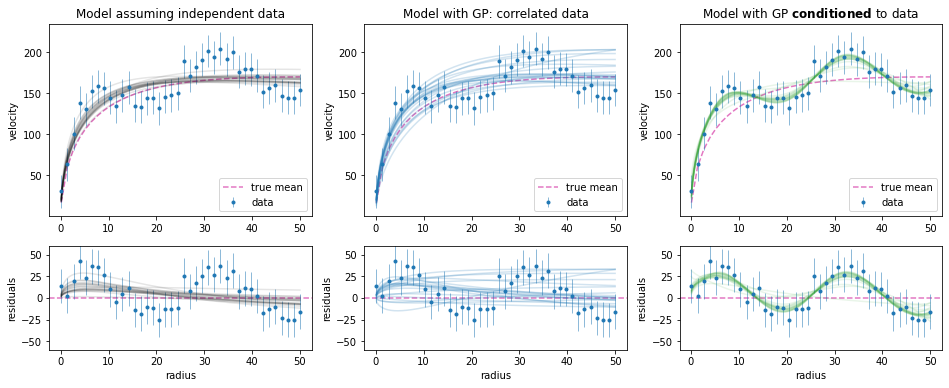

In [396]:
fig,ax = plt.subplots(figsize=(16,6), ncols=3, nrows=2, gridspec_kw={'height_ratios':(0.65,0.35)})

def commons(ax, i):
    # rotation curve
    ax[0,i].plot(x, jax_vhalo({'log_mh':lmh, 'log_c':lc}, x), '--', c='tab:pink', label='true mean')
    ax[0,i].errorbar(x, vm, yerr=e_vm, fmt='.', c='C0', lw=0.5, label='data')
    ax[0,i].legend(loc='lower right')
    ax[0,i].set_ylabel('velocity');
    # residuals
    ax[1,i].axhline(y=0, ls='--', c='tab:pink')
    ax[1,i].errorbar(x, vm-jax_vhalo({'log_mh':lmh, 'log_c':lc}, x), yerr=e_vm, fmt='.', c='C0', lw=0.5)
    ax[1,i].set_xlabel('radius')
    ax[1,i].set_ylabel('residuals')
    ax[1,i].set_ylim(-60,60);
    
commons(ax,0)
commons(ax,1)
commons(ax,2)

ax[0,0].plot(r_grid, pred_wn[inds].T, 'k', alpha=0.1)
ax[0,1].plot(r_grid, pred[inds].T, 'C0', alpha=0.2)
ax[0,2].plot(r_grid, pred_cd[inds].T, 'C2', alpha=0.1)
ax[1,0].plot(r_grid, (pred_wn[inds]-jax_vhalo({'log_mh':lmh, 'log_c':lc}, r_grid)).T, 'k', alpha=0.1)
ax[1,1].plot(r_grid, (pred[inds]-jax_vhalo({'log_mh':lmh, 'log_c':lc}, r_grid)).T, 'C0', alpha=0.2)
ax[1,2].plot(r_grid, (pred_cd[inds]-jax_vhalo({'log_mh':lmh, 'log_c':lc}, r_grid)).T, 'C2', alpha=0.1);
ax[0,0].set_title("Model assuming independent data");
ax[0,1].set_title("Model with GP: correlated data");
ax[0,2].set_title("Model with GP "+r"$\rm\bf conditioned$"+" to data");

In the left-hand panels we compare 20 random samples of the predicted rotation curve for the first iteration of the model, i.e. the one treating each datapoint as independent. We see that the model rotation curves (in black) tend to overshoot the mean at small radii and tend to fall below it at large radii - this becomes particularly clear in the residuals plot. The reason for this discrepancy is that this model finds a biased result, predicting a higher concentration and a lower mass than the true values.

The middle panels similarly compare samples of the predictions of the second model, i.e. the one that uses GPs to model correlations among successive datapoints. We see that while the prediction of the rotation curve (in blue) becomes much less accurate, it is now unbiased. In fact, the true mean rotation curve that we used to generate the dataset is very well encompassed by the random samples of this model.

The right panels demonstrate why such a large variety of rotation curve shapes in the blue model is consistent with the dataset. In fact, each blue curve is itself a GP and when [conditioning](https://en.wikipedia.org/wiki/Conditioning_(probability)) it to the measurements we obtain the green curves in the right panels, which are all consistent with the data (reduced $\chi^2$ less than unity). 